<a href="https://colab.research.google.com/github/MaryamNikpasand/Grading/blob/main/Joint/GradingJoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import tensorflow as tf
!pip install -q -U keras-tuner
import keras_tuner as kt
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from scipy import ndimage
from tensorflow.keras import regularizers
from tensorflow.keras import initializers


     |████████████████████████████████| 98 kB 5.4 MB/s 


In [5]:
def read_files(filepath):
  """Read and load volume"""
  # Read file
  scan=plt.imread(filepath)
  plt.imshow(scan, cmap = plt.cm.gray)
  plt.show()
#   Get raw data
  return scan

# def normalize(volume):
#   """normalize the volume
#      The max value for normalization is: np.mean(max_all)+2*np.std(max_all)
#      The min value of all images in this dataset is 0
# """
#   min=0
#   max=1007.2348186941014
#   volume[volume<min]=min
#   volume[volume>max]=max
#   volume=(volume-min)/(max-min)
#   volume=volume.astype("float32")
#   return volume

# def normalize(volume):
#   """normalize the volume
#      Normalize with max and min of each image
# """
#   min=np.min(volume)
#   max=np.max(volume)
#   volume=(volume-min)/(max-min)
#   volume=volume.astype("float32")
#   return volume

def normalize(volume):
  """normalize the volume
     Normalize with mean and std of each image
"""
  Mean=np.mean(volume)
  Std=np.std(volume)
  volume=(volume-Mean)/Std
  volume=volume.astype("float32")
  return volume

def resize_volume(img):
  """Resize across z-axis"""
  # Set the desired depth
  desired_width = 64
  desired_height = 64
  # Get current depth
  current_width = img.shape[0]
  current_height = img.shape[-1]
  # Compute depth factor
  width = current_width / desired_width
  height = current_height / desired_height
  width_factor = 1 / width
  height_factor = 1 / height
  # Resize across z-axis
  img = ndimage.zoom(img, (width_factor, height_factor), order=1)
  # resize_and_rescale = tf.keras.Sequential([
  #   layers.experimental.preprocessing.Resizing(desired_width, desired_height, desired_depth)])
  # img = resize_and_rescale(tf.expand_dims(img, axis=-1))
  return img

def process_scan(path):
  """Read and resize volume"""
  # Read scan
  volume=read_files(path)
  # Normalize
  volume=normalize(volume)
  volume=resize_volume(volume)
  volume=tf.expand_dims(volume,axis=-1) #  Adding an extra dimension to the images to have them in (x,x,1) format 
  return volume

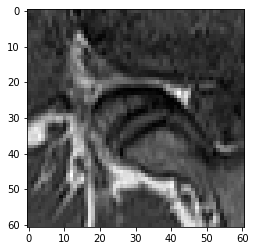

TensorShape([64, 64, 1])

In [8]:
filepath = '/content/drive/MyDrive/PhD/Barocas/grading/LumbarDiscJointScoring_Main/ImageSelection/Joints/Takahashi/grade1/T1_TSE_TRA__0004_009.ima_left.png'
scan = process_scan(filepath)
scan.shape

In [5]:
# Folder "Joint" consist of MRI scans having Joint images,
Joint_paths = dict()
filepath_Joint='/content/drive/MyDrive/PhD/Barocas/grading/LumbarDiscJointScoring_Main/ImageSelection/Joints/Takahashi'
for x in os.listdir(filepath_Joint):
    for y in os.listdir(os.path.join(filepath_Joint,x)):
        if x not in Joint_paths:
            Joint_paths[x] = [os.path.join(filepath_Joint, x, y)]
        else:
            Joint_paths[x].append(os.path.join(filepath_Joint, x, y))

print("Joint['grade1']:: " + str(len(Joint_paths['grade1'])))
print("Joint['grade2']:: " + str(len(Joint_paths['grade2'])))
print("Joint['grade3']:: " + str(len(Joint_paths['grade3'])))
print("Joint['grade4']:: " + str(len(Joint_paths['grade4'])))

# Read and process the scans.
Joint_grade1 = np.array([process_scan(path) for path in Joint_paths['grade1']])
Joint_grade2 = np.array([process_scan(path) for path in Joint_paths['grade2']])
Joint_grade3 = np.array([process_scan(path) for path in Joint_paths['grade3']])
Joint_grade4 = np.array([process_scan(path) for path in Joint_paths['grade4']])



Joint['grade1']:: 926
Joint['grade2']:: 841
Joint['grade3']:: 462
Joint['grade4']:: 148


In [14]:
# For the Joint images assign 1-5
Joint_grade1_labels=np.array([[1, 0, 0, 0] for _ in range(len(Joint_grade1))])
Joint_grade2_labels=np.array([[0, 1, 0, 0] for _ in range(len(Joint_grade2))])
Joint_grade3_labels=np.array([[0, 0, 1, 0] for _ in range(len(Joint_grade3))])
Joint_grade4_labels=np.array([[0, 0, 0, 1] for _ in range(len(Joint_grade4))])

Joint_grade1_train_limit=int(len(Joint_paths['grade1'])*.9)
Joint_grade2_train_limit=int(len(Joint_paths['grade2'])*.9)
Joint_grade3_train_limit=int(len(Joint_paths['grade3'])*.9)
Joint_grade4_train_limit=int(len(Joint_paths['grade4'])*.9)

Joint_grade1_val_limit=int(len(Joint_paths['grade1'])*.1)+Joint_grade1_train_limit
Joint_grade2_val_limit=int(len(Joint_paths['grade2'])*.1)+Joint_grade2_train_limit
Joint_grade3_val_limit=int(len(Joint_paths['grade3'])*.1)+Joint_grade3_train_limit
Joint_grade4_val_limit=int(len(Joint_paths['grade4'])*.1)+Joint_grade4_train_limit

# Split data in the ratio 70-30 for training and validation.
x_train=np.concatenate((Joint_grade1[:Joint_grade1_train_limit],
                        Joint_grade2[:Joint_grade2_train_limit],
                        Joint_grade3[:Joint_grade3_train_limit],
                        Joint_grade4[:Joint_grade4_train_limit]),axis=0)

y_train=np.concatenate((Joint_grade1_labels[:Joint_grade1_train_limit],
                        Joint_grade2_labels[:Joint_grade2_train_limit],
                        Joint_grade3_labels[:Joint_grade3_train_limit],
                        Joint_grade4_labels[:Joint_grade4_train_limit]),axis=0)

x_val=np.concatenate((Joint_grade1[Joint_grade1_train_limit:],
                      Joint_grade2[Joint_grade2_train_limit:],
                      Joint_grade3[Joint_grade3_train_limit:],
                      Joint_grade4[Joint_grade4_train_limit:]),axis=0)

y_val=np.concatenate((Joint_grade1_labels[Joint_grade1_train_limit:],
                      Joint_grade2_labels[Joint_grade2_train_limit:],
                      Joint_grade3_labels[Joint_grade3_train_limit:],
                      Joint_grade4_labels[Joint_grade4_train_limit:]),axis=0)

print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

# Define data loaders
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train ))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

Number of samples in train and validation are 2137 and 240.


In [15]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

# # Visualize a set of images
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 10))
# for images,labels in train_dataset.take(1):
#   for i in range(9):
#     ax=plt.subplot(3,3,i+1)
#     plt.imshow(np.squeeze(images[i].numpy()),cmap='gray')
#     plt.title(int(labels[i]))
#     plt.axis("off")

# Data augmentation
data_augmentation=keras.Sequential([
                                    layers.experimental.preprocessing.RandomFlip("horizontal"),
                                    layers.experimental.preprocessing.RandomRotation(.1)
])

In [16]:

def get_model_3D_CTscans(input_shape):
  """Build a 2D convolutional neural network model."""

  inputs = keras.Input(shape=input_shape)
  print(inputs.shape)
  # Image augmentation
  x=data_augmentation(inputs)

  x=layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='valid', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
  x=layers.MaxPool2D(pool_size=2)(x)
  x=layers.BatchNormalization()(x)

  x=layers.Conv2D(filters=64,kernel_size=3,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
  x=layers.MaxPool2D(pool_size=2)(x)
  x=layers.BatchNormalization()(x)

  x=layers.Conv2D(filters=128,kernel_size=3,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
  x=layers.MaxPool2D(pool_size=2)(x)
  x=layers.BatchNormalization()(x)

  x=layers.Conv2D(filters=256,kernel_size=3,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
  x=layers.MaxPool2D(pool_size=2)(x)
  x=layers.BatchNormalization()(x)

  x=layers.GlobalAveragePooling2D()(x)
  x=layers.Dense(units=512,activation='relu', kernel_regularizer=regularizers.l2(.001))(x)
  x=layers.Dropout(.3)(x)

  outputs=layers.Dense(units=4,activation='softmax')(x)

  model=keras.Model(inputs,outputs,name='2dcnn')
  return model

image_size=(64,64)
model=get_model_3D_CTscans(input_shape=image_size + (1,))
model.summary()


(None, 64, 64, 1)
Model: "2dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29,

In [17]:
# %% Compile the model
initial_learning_rate=1e-4
lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate,decay_steps=1e5,decay_rate=.96,staircase=True)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy'])

# Define callbacks
directory = "3D_CTscan" # Save the entire model as a SavedModel.
parent_dir = os.getcwd() # Parent Directory path
path = os.path.join(parent_dir, directory) # Path
os.makedirs(path,exist_ok=True) # Create the directory
checkpoint_path = Path(os.path.join(path,'2d_image_classification.h5'))
checkpoint_cb=keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,monitor='val_accuracy',save_best_only=True)

epochs=50
history=model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],
)

Epoch 1/50
67/67 - 13s - loss: 1.0495 - accuracy: 0.3435 - val_loss: 0.9850 - val_accuracy: 0.3542 - 13s/epoch - 192ms/step
Epoch 2/50
67/67 - 1s - loss: 0.9866 - accuracy: 0.3968 - val_loss: 0.9734 - val_accuracy: 0.3542 - 697ms/epoch - 10ms/step
Epoch 3/50
67/67 - 1s - loss: 0.9656 - accuracy: 0.4024 - val_loss: 1.0113 - val_accuracy: 0.4042 - 775ms/epoch - 12ms/step
Epoch 4/50
67/67 - 1s - loss: 0.9477 - accuracy: 0.4221 - val_loss: 1.0082 - val_accuracy: 0.3792 - 693ms/epoch - 10ms/step
Epoch 5/50
67/67 - 1s - loss: 0.9354 - accuracy: 0.4328 - val_loss: 1.0105 - val_accuracy: 0.4083 - 754ms/epoch - 11ms/step
Epoch 6/50
67/67 - 1s - loss: 0.9269 - accuracy: 0.4431 - val_loss: 0.9608 - val_accuracy: 0.4333 - 754ms/epoch - 11ms/step
Epoch 7/50
67/67 - 1s - loss: 0.9126 - accuracy: 0.4375 - val_loss: 0.9370 - val_accuracy: 0.4417 - 748ms/epoch - 11ms/step
Epoch 8/50
67/67 - 1s - loss: 0.8989 - accuracy: 0.4605 - val_loss: 0.9259 - val_accuracy: 0.4583 - 757ms/epoch - 11ms/step
Epoch 9/

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


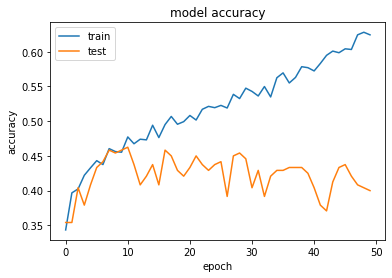

In [18]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

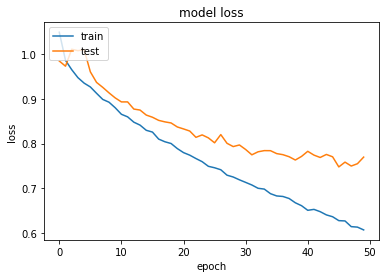

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
# %% Model
def get_model_Niemeyer_Paper(input_shape):
#   """Build a 2D convolutional neural network model."""

  inputs = keras.Input(shape=input_shape)
  # Image augmentation
  x=data_augmentation(inputs)

  x=layers.Conv2D(filters=32,kernel_size=3,strides=1,padding='same',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)
  x=layers.Dropout(.2)(x)

  x=layers.Conv2D(filters=64,kernel_size=3,dilation_rate=2,strides=1,padding='same',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)
  x=layers.Conv2D(filters=64,kernel_size=3,dilation_rate=2,strides=1,padding='same',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)    
  x=layers.Dropout(.2)(x)
  x=layers.MaxPool2D(pool_size=2)(x)

  x=layers.Conv2D(filters=128,kernel_size=3,dilation_rate=2,strides=1,padding='same',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)
  x=layers.Conv2D(filters=128,kernel_size=3,dilation_rate=2,strides=1,padding='same',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)
  x=layers.Dropout(.2)(x)

  x=layers.Conv2D(filters=256,kernel_size=3,dilation_rate=3,strides=1,padding='same',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)
  x=layers.Conv2D(filters=256,kernel_size=3,dilation_rate=3,strides=1,padding='same',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)
  x=layers.Dropout(.2)(x)
  x=layers.MaxPool2D(pool_size=2)(x)

  x=layers.Conv2D(filters=512,kernel_size=3,strides=1,padding='valid',
                  activation=layers.LeakyReLU(alpha=.01),
                  kernel_regularizer=regularizers.l2(5e-4),
                  kernel_initializer=initializers.HeNormal())(x)
  x=layers.BatchNormalization()(x)
  x=layers.Dropout(.2)(x)

  x=layers.GlobalAveragePooling2D()(x)
  x=layers.Dense(units=512,activation='relu')(x)

  outputs=layers.Dense(units=4,activation='softmax')(x) #change this to softmax when working wiht gradings

  model=keras.Model(inputs,outputs,name='2dcnn')
  return model

image_size=(64,64)
model=get_model_Niemeyer_Paper(input_shape=image_size + (1,))
model.summary()

Model: "2dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                             

In [21]:
# %% Compile the model
epochs=50
initial_learning_rate=1e-3
num_steps=np.floor(len(x_train)/batch_size)
boundaries=[]
values=[initial_learning_rate]
indx=1
while indx<int(epochs/10):
    boundaries.append(indx*10*num_steps)
    values.append(initial_learning_rate/(10**(indx)))
    indx+=1

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries,values)
# lr_schedule=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate,decay_steps=1e5,decay_rate=.96,staircase=True)

model.compile(
    # loss=tf.keras.losses.CategoricalCrossentropy(),
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=lr_schedule, momentum=.9),
    metrics=['accuracy'])

# Define callbacks
directory = "Niemeyer_Paper" # Save the entire model as a SavedModel.
parent_dir = os.getcwd() # Parent Directory path
path = os.path.join(parent_dir, directory) # Path
os.makedirs(path,exist_ok=True) # Create the directory
checkpoint_path = Path(os.path.join(path,'2d_image_classification.h5'))
checkpoint_cb=keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                              monitor='val_accuracy',
                                              verbose=1,
                                              save_best_only=True,
                                              save_weights_only=True
                                              )


history=model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],
)

Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.36667, saving model to /content/Niemeyer_Paper/2d_image_classification.h5
67/67 - 12s - loss: 2.1076 - accuracy: 0.3229 - val_loss: 2.0707 - val_accuracy: 0.3667 - 12s/epoch - 182ms/step
Epoch 2/50

Epoch 00002: val_accuracy did not improve from 0.36667
67/67 - 7s - loss: 2.0578 - accuracy: 0.3832 - val_loss: 1.9664 - val_accuracy: 0.3625 - 7s/epoch - 105ms/step
Epoch 3/50

Epoch 00003: val_accuracy improved from 0.36667 to 0.37083, saving model to /content/Niemeyer_Paper/2d_image_classification.h5
67/67 - 7s - loss: 2.0169 - accuracy: 0.3823 - val_loss: 1.9665 - val_accuracy: 0.3708 - 7s/epoch - 107ms/step
Epoch 4/50

Epoch 00004: val_accuracy did not improve from 0.37083
67/67 - 7s - loss: 1.9885 - accuracy: 0.3814 - val_loss: 1.9837 - val_accuracy: 0.3667 - 7s/epoch - 106ms/step
Epoch 5/50

Epoch 00005: val_accuracy did not improve from 0.37083
67/67 - 7s - loss: 1.9734 - accuracy: 0.3804 - val_loss: 1.9931 - val_accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


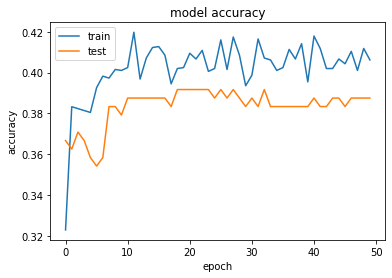

In [22]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

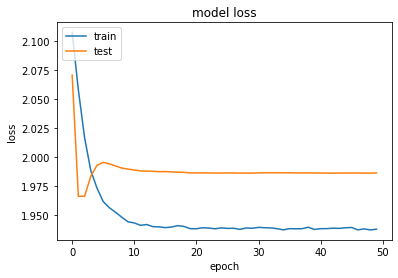

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [1]:
def get_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

image_size=(64,64)
model = get_model(input_shape=image_size + (1,), num_classes=4)
# keras.utils.plot_model(model, show_shapes=True)
model.summary()

NameError: ignored

In [25]:
directory = "classification_from_scratch" # Save the entire model as a SavedModel.
parent_dir = os.getcwd() # Parent Directory path
path = os.path.join(parent_dir, directory) # Path
os.makedirs(path,exist_ok=True) # Create the directory
checkpoint_path = Path(os.path.join(path,"save_at_{epoch}.h5"))

epochs = 50

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                              monitor='val_accuracy',
                                              verbose=1,
                                              save_best_only=True,
                                              save_weights_only=True
                                              )

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_dataset, 
    epochs=epochs, 
    callbacks=[checkpoint_cb], 
    validation_data=validation_dataset,
)

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 251.3151 - accuracy: 0.3472
Epoch 00001: val_accuracy improved from -inf to 0.38750, saving model to /content/classification_from_scratch/save_at_1.h5
67/67 [==============================] - 6s 49ms/step - loss: 251.3151 - accuracy: 0.3472 - val_loss: 32.9747 - val_accuracy: 0.3875
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 11.6843 - accuracy: 0.3828
Epoch 00002: val_accuracy did not improve from 0.38750
67/67 [==============================] - 2s 30ms/step - loss: 11.6843 - accuracy: 0.3828 - val_loss: 3.9161 - val_accuracy: 0.3875
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 3.0619 - accuracy: 0.3875
Epoch 00003: val_accuracy did not improve from 0.38750
67/67 [==============================] - 2s 29ms/step - loss: 3.0619 - accuracy: 0.3875 - val_loss: 2.7897 - val_accuracy: 0.3875
Epoch 4/50
67/67 [==============================] - ETA: 0s - loss: 2.7972 - accuracy: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


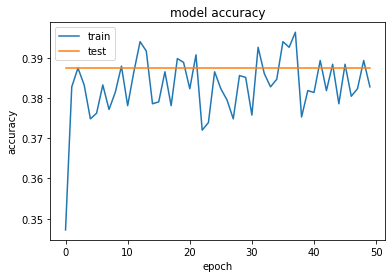

In [26]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

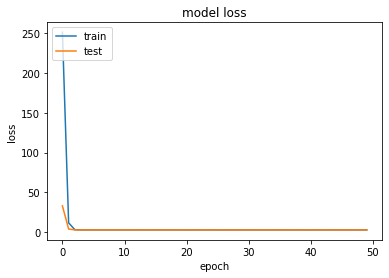

In [27]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()